In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.manifold import TSNE

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup
import scipy
from scipy.sparse import coo_matrix, hstack


# Dataset loading

In [3]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

In [4]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [5]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [6]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [7]:
df = pd.DataFrame(dataset2['PTags'].tolist()).stack().value_counts()
#df = df[df>50]
df.shape

(36578,)

In [8]:
existintags = set(df.index)
existintags

{"['android-studio-3.0']",
 "['xlsx', 'xlsxwriter', 'perl6']",
 "['maven', 'gradle', 'groovy']",
 "['c#', 'android']",
 "['java-ee', 'jenkins', 'gradle']",
 "['python', 'object', 'import', 'scripting', 'maya']",
 "['css', 'r-markdown', 'slidify']",
 "['ionic2']",
 "['c#', 'selenium', 'selenium-webdriver', 'fiddler', 'remotewebdriver']",
 "['java', 'json', 'moxy', 'modeshape']",
 "['wordpress', 'algolia']",
 "['angular', 'input', 'ionic3', 'onchange', 'ngfor']",
 "['ios', 'swift', 'uipageviewcontroller', 'uipagecontrol', 'iphone-x']",
 "['javascript', 'node.js', 'asynchronous', 'callback']",
 "['ruby-on-rails-3', 'scopes']",
 "['php', 'sendgrid', 'mass-emails']",
 "['spring', 'spring-boot', 'swagger', 'swagger-ui', 'swagger-2.0']",
 "['azure', 'azure-active-directory', 'access-token']",
 "['node.js', 'azure', 'peerjs']",
 "['spring', 'performance', 'spring-boot', 'design-patterns', 'design']",
 "['android', 'ibeacon', 'eddystone', 'android-ibeacon']",
 "['javascript', 'html', 'angular',

# Dataset splitting

In [9]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

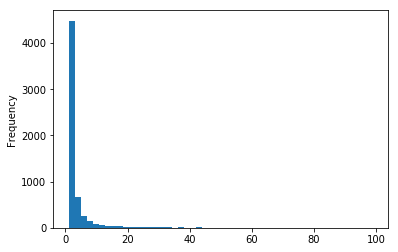

In [10]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()

In [11]:
popularitytags = df[df>10].to_dict()
len(popularitytags)

384

In [12]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(9065, 12)


PTagsCleaned  \
Id                                         
48124513      [javascript, jquery, html]   
48168041                   [git, github]   
48177702                             [c]   
48050926  [javascript, node.js, mongodb]   
48071118            [apache, ssl, nginx]   

                                                     PTags  \
Id                                                           
48124513                        [javascript, jquery, html]   
48168041        [git, github, bitcoin, git-fork, bitcoind]   
48177702  [c, timer, embedded, microcontroller, microchip]   
48050926                    [javascript, node.js, mongodb]   
48071118          [apache, ssl, nginx, proxy, transparent]   

                                                      TCode  
Id                                                           
48124513  < script src =" https :/ / ajax . googleapis ....  
48168041                                               None  
48177702  void init16 () { T2CONbits . ON = ;/ / Timer d...  
48050926  " INPUT_STRING " ALLOWED_STRING MATCHED str1 ,...  
48071118  ProxyRequests Off < Proxy *> Order deny , allo...

In [13]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [14]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(9065, 384)

In [15]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

In [16]:
mlb.classes_

array(['active-directory', 'ajax', 'algorithm', 'amazon-ec2', 'amazon-s3',
       'amazon-web-services', 'anaconda', 'android', 'android-fragments',
       'android-gradle', 'android-layout', 'android-recyclerview',
       'android-studio', 'angular', 'angular-material', 'angular5',
       'angularjs', 'animation', 'apache', 'apache-kafka', 'apache-spark',
       'apache-spark-sql', 'api', 'arrays', 'asp.net', 'asp.net-core',
       'asp.net-core-2.0', 'asp.net-mvc', 'asp.net-web-api', 'assembly',
       'asynchronous', 'audio', 'authentication', 'automation',
       'aws-lambda', 'axios', 'azure', 'bash', 'batch-file',
       'beautifulsoup', 'bootstrap-4', 'c', 'c#', 'c++', 'c++11',
       'caching', 'cakephp', 'canvas', 'casting', 'chart.js', 'charts',
       'checkbox', 'class', 'cmake', 'cmd', 'codeigniter',
       'computer-vision', 'concurrency', 'cookies', 'cordova', 'cors',
       'css', 'css3', 'csv', 'curl', 'd3.js', 'database', 'dataframe',
       'datagridview', 'datatable

# LDA version

In [17]:

class CustomLDA(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.lda_params = {'n_components':10, 'random_state':0, 'doc_topic_prior':None, 'topic_word_prior':None}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'lda_'+k:v for k,v in self.lda_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #LDA preparation
        self.lda = LatentDirichletAllocation(learning_method = 'batch', **self.lda_params)
        self.lda.fit(Xtrans)
        
        self.components_ = self.lda.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        lda = self.lda.transform(self.transformcvect(X))
        return lda
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.lda_params = {k[4:]:v for k,v in self.params.items() if k.startswith('lda_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.lda_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def perplexity(self, X):
        
        return self.lda.perplexity(self.transformcvect(X))
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]



#customLDA = CustomLDA()


Some docs about the parameters : https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [207]:
topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1),}

customLDA = CustomLDA(**params)
customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [208]:
#Filling rating
customLDA.score()

47.5

In [209]:
#Main topics
customLDA.describe_topics(ntopwords=10, ntopics=20)

array([['view', 'scroll', 'layout', 'content', 'like', 'set', 'onli',
        'problem', 'need', 'render'],
       ['method', 'get', 'observ', 'use', 'cach', 'code', 'like',
        'asynchron', 'oper', 'realm'],
       ['get', 'use', 'scope', 'ani', 'type', 'creat', 'need', 'follow',
        'want', 'u0_a110'],
       ['window', 'open', 'modal', 'work', 'use', 'ani', 'run', 'script',
        'want', 'like'],
       ['spring', 'token', 'api', 'use', 'boot', 'get', 'return',
        'respons', 'request', 'access'],
       ['cluster', 'get', 'file', 'save', 'creat', 'run', 'pod',
        'kubernet', 'firebas', 'connect'],
       ['data', 'session', 'use', 'like', 'fetch', 'way', 'get', 'want',
        'show', 'expir'],
       ['project', 'build', 'gradl', 'use', 'version', 'problem', 'modul',
        'one', 'updat', 'ani'],
       ['document', 'tri', 'get', 'express', 'code', 'set', 'assign',
        'file', 'refer', 'ani'],
       ['servic', 'googl', 'use', 'regist', 'internet', 'catego

In [210]:
#Perplexity
customLDA.perplexity(X_test)

8370.6942681397813

In [ ]:
customLDA.topicscnamed

In [211]:
customLDA.namedtopics

{'ajax': {22},
 'android': {12, 94},
 'angular': {11},
 'apache': {90},
 'api': {4, 42},
 'audio': {39},
 'browser': {23},
 'button': {48},
 'checkbox': {38},
 'class': {29, 59, 63, 88},
 'cloud': {34},
 'css': {60},
 'csv': {80},
 'date': {30},
 'docker': {57},
 'download': {80},
 'email': {87},
 'excel': {58},
 'express': {8},
 'file': {5, 44, 80, 89},
 'filter': {84},
 'function': {55, 69, 82, 93},
 'git': {73},
 'github': {73},
 'graph': {32},
 'hibernate': {90},
 'html': {11, 55, 60, 77},
 'input': {14, 43},
 'java': {12, 90},
 'javascript': {55},
 'json': {15},
 'laravel': {21},
 'list': {72},
 'magento': {70},
 'maven': {95},
 'mysql': {64},
 'object': {15, 88},
 'pdf': {25},
 'php': {21},
 'pip': {81},
 'plot': {61},
 'post': {22},
 'redirect': {23, 37},
 'rest': {42},
 'scroll': {0},
 'select': {62},
 'server': {51, 79, 89, 98},
 'session': {6},
 'spring': {4},
 'sql': {64},
 'string': {68, 69, 82},
 'text': {19, 24},
 'url': {45},
 'video': {39},
 'web': {13},
 'xamarin': {16

# TSNE reduction dimension

In [212]:
#customLDA
X_lda = customLDA.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_lda)

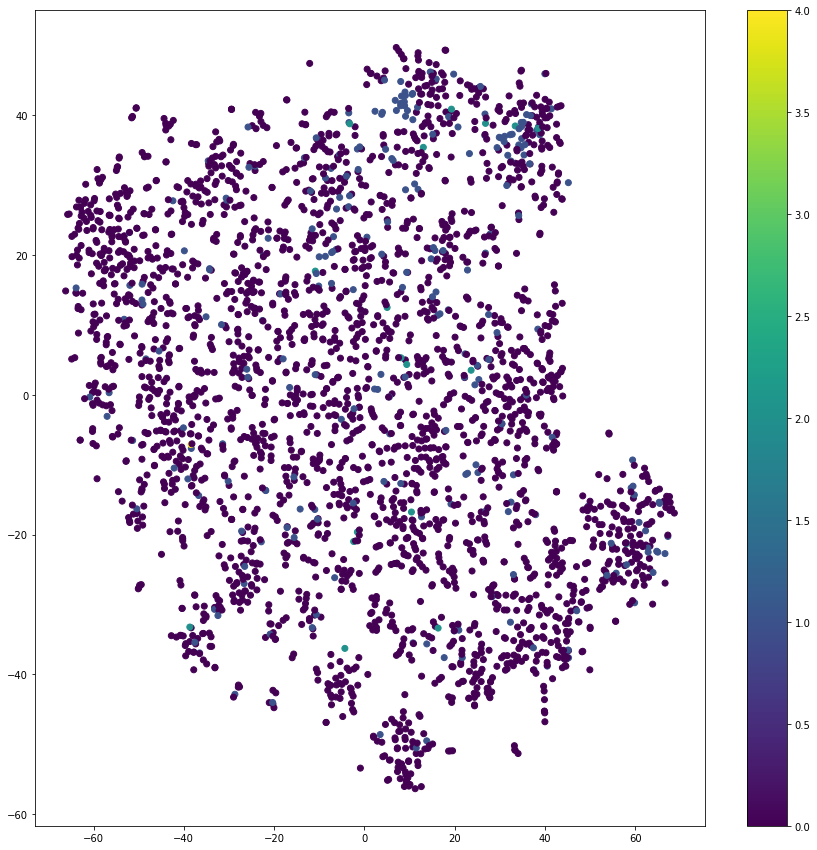

In [214]:
# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_lda, 0)[:, 0]
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

# GridsearchCV LDA

In [216]:
#gridsearch to optimize the parameters - LDA optimization

topics = 100

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)
}

customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'lda_topic_word_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'clf_merge': [True, False],
             }



clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143, score=35.16666666666667, total=  36.1s
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333, score=49.33333333333333, total=  36.0s
[CV]  clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.007142857142857143, score=48.33333333333333, total=  36.3s
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word_prior=0.008333333333333333 
[CV] clf_merge=True, lda_doc_topic_prior=0.007142857142857143, lda_topic_word

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.5min


[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.0125, score=52.33333333333333, total=  35.0s
[CV] clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.0125, score=32.33333333333333, total=  35.9s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666, score=49.83333333333333, total=  36.1s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143 
[CV]  clf_merge=True, lda_doc_topic_prior=0.01, lda_topic_word_prior=0.016666666666666666, score=32.0, total=  35.9s
[CV] clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.008333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.0125, lda_topic_word_prior=0.007142857142857143, score=49.833333333333336, total=  35.0s
[CV] clf_merge=True, l

[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed: 10.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.007142857142857143, 0.008333333333333333, 0.01, 0.0125, 0.016666666666666666], 'lda_topic_word_prior': [0.007142857142857143, 0.008333333333333333, 0.01, 0.0125, 0.016666666666666666], 'clf_merge': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [217]:
clf.best_params_

{'clf_merge': True,
 'lda_doc_topic_prior': 0.0125,
 'lda_topic_word_prior': 0.01}

In [218]:
clf.best_score_

45.25

In [219]:
#Parameters update
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.01,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

# Results comparison --> Unsupervised vs Supervised

In [220]:
#Metrics creation

#from sklearn.metrics import fbeta_score
scorer = make_scorer(f1_score, average='micro')


In [222]:
#gridsearch to optimize the parameters - TEXT merged

customLDA = CustomLDA(**params)

parameters = {'vect_1_max_df': [1., 0.9, 0.95],
              'vect_1_max_features': [15000,18000,12000],
              'vect_1_min_df': [1, 10, 20],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.08579210167952792, total=  36.5s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.06352574985851726, total=  40.9s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.07975705266522816, total=  40.9s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.10321855686652219, total=  35.4s
[CV] vect_1_max_df=1.0, vect_1_max_features=18000, vect_1_min_df=1 ...


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  6.2min


[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=1, score=0.07975705266522816, total=  42.1s
[CV] vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=10, score=0.10321855686652219, total=  35.6s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.08683001531393568, total=  33.8s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.10213042771182305, total=  33.6s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10, score=0.08579210167952792, total=  35.7s
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1, score=0.06299323562570

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed: 12.3min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.9, 0.95], 'vect_1_max_features': [15000, 18000, 12000], 'vect_1_min_df': [1, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [223]:
clf.best_score_

0.094505329273025046

In [224]:
clf.best_params_

{'vect_1_max_df': 1.0, 'vect_1_max_features': 15000, 'vect_1_min_df': 10}

In [225]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.10473512198829521

In [226]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.01,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 10,
 'vect_1_ngram_range': (1, 1)}

In [228]:
#gridsearch to optimize the parameters - LDA optimization - Final round
customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*0.9), 1/(topics), 1/(topics*0.8), 1/(topics*0.7)],
              'lda_topic_word_prior':[ 1/(topics*1.1), 1/(topics), 1/(topics*0.9), 1/(topics*0.8)],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring = scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909, score=0.08896505476492064, total=  35.2s
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.00909090909090909, score=0.10335286458333333, total=  35.1s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01 
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.01, score=0.08724881256850565, total=  36.2s
[CV] lda_doc_topic_prior=0.011111111111111112, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.011111111111111112, lda_top

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.8min


[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.01, score=0.08512505484861782, total=  36.7s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.01, score=0.11150152260482549, total=  36.1s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112, score=0.08462286013306422, total=  36.3s
[CV] lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125 
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.011111111111111112, score=0.11170501200712682, total=  36.2s
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.08183188572248941, total=  33.0s
[CV]  lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.0125, score=0.11113734750098386, total=  33.2s


[Parallel(n_jobs=3)]: Done  32 out of  32 | elapsed:  7.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0, lda_topic_word_prior=0.01,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10,
     vec...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.011111111111111112, 0.01, 0.0125, 0.014285714285714285], 'lda_topic_word_prior': [0.00909090909090909, 0.01, 0.011111111111111112, 0.0125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [229]:
clf.best_score_

0.10033142704073042

In [230]:
clf.best_params_

{'lda_doc_topic_prior': 0.0125, 'lda_topic_word_prior': 0.011111111111111112}

In [231]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.10668087049155379

In [232]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.0125,
 'lda_n_components': 100,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.011111111111111112,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 10,
 'vect_1_ngram_range': (1, 1)}

In [19]:
#Direct calculation

customLDA = CustomLDA(**params)

customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.0125,
     lda_n_components=100, lda_random_state=0,
     lda_topic_word_prior=0.011111111111111112, vect_1_max_df=1.0,
     vect_1_max_features=15000, vect_1_min_df=10,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=None, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [21]:
customLDA.set_params(clf_popmax=0.15)
customLDA.topic_popularity(X_train)
customLDA.too_popular_topics

[99]

In [22]:
# Topics verification - Too popular
customLDA.describe_topics(ntopwords=20, ntopics=100)[[99]]

array([['user', 'id', 'databas', 'save', 'name', 'need', 'one', 'get',
        'field', 'model', 'want', 'relat', 'data', 'onli', 'like',
        'serial', 'tabl', 'use', 'mani', 'add']],
      dtype='<U15')

In [23]:
# Topics verification - 20 first
customLDA.describe_topics(ntopwords=20, ntopics=20)

array([['post', 'side', 'batch', 'jar', 'server', 'twice', 'publish',
        'add', 'layer', 'show', 'my', 'spring', 'new', 'custom', 'page',
        'time', 'put', 'see', 'singl', 'use'],
       ['01', '2018', '00', '17', '12', '05', 'price', '2017', '27', '31',
        'boolean', 'seri', 'app', 'date', 'time', 'android', '09', 'divid',
        '02', 'com'],
       ['dynam', 'task', 'want', 'use', 'code', 'paramet', 'pass',
        'vendor', 'creat', 'way', 'self', 'call', 'new', 'toast', 'stack',
        'tree', 'possibl', 'abov', 'instanc', 'generic'],
       ['googl', 'chrome', 'crash', 'work', 'firefox', 'ani', 'tri',
        'find', 'seem', 'doe', 'safari', 'fine', 'use', 'point', 'app',
        'browser', 'look', 'problem', 'report', 'caus'],
       ['chart', 'facebook', 'this', 'certif', 'ssl', 'bar', 'show',
        'progress', 'follow', 'server', 'tri', 'doe', 'screenshot', 'want',
        'work', 'thank', 'configur', 'display', 'need', 'onli'],
       ['url', 'page', 'com',

In [24]:
print(len(customLDA.namedtopics))
customLDA.namedtopics

66


{'ajax': {33},
 'android': {24, 75},
 'angular': {43},
 'api': {53},
 'audio': {90},
 'browser': {60},
 'button': {41},
 'checkbox': {14},
 'class': {15},
 'css': {46},
 'csv': {54},
 'date': {28},
 'django': {30},
 'docker': {62},
 'elasticsearch': {90},
 'email': {64},
 'excel': {63},
 'express': {79},
 'facebook': {4},
 'fetch': {59},
 'file': {8, 18, 54, 56},
 'filter': {11},
 'firefox': {3},
 'function': {19, 33, 73},
 'git': {81},
 'html': {66, 96},
 'https': {5},
 'jar': {0},
 'java': {26},
 'javascript': {60, 96},
 'join': {39},
 'json': {25, 63},
 'laravel': {66},
 'linux': {42},
 'list': {12},
 'listview': {6},
 'matrix': {42},
 'maven': {49},
 'nginx': {88},
 'npm': {63},
 'object': {67},
 'pdf': {72},
 'php': {56},
 'post': {0},
 'python': {74, 94},
 'random': {10},
 'redirect': {5},
 'search': {39},
 'select': {97},
 'server': {0, 18, 57, 60},
 'spring': {71},
 'sql': {23, 76},
 'ssl': {4},
 'string': {31, 65},
 'swift': {7},
 'tensorflow': {55},
 'text': {83, 87},
 'time'

In [25]:
customLDA.topicsnamed

{0: ['post', 'jar', 'server'],
 1: [],
 2: [],
 3: ['firefox'],
 4: ['facebook', 'ssl'],
 5: ['url', 'redirect', 'https'],
 6: ['listview'],
 7: ['swift', 'xcode', 'wordpress'],
 8: ['file'],
 9: [],
 10: ['random'],
 11: ['filter'],
 12: ['list'],
 13: ['time'],
 14: ['checkbox'],
 15: ['class'],
 16: [],
 17: ['tomcat'],
 18: ['file', 'server'],
 19: ['function'],
 20: [],
 21: [],
 22: [],
 23: ['sql'],
 24: ['android'],
 25: ['json'],
 26: ['java'],
 27: [],
 28: ['date', 'time'],
 29: [],
 30: ['django'],
 31: ['string'],
 32: [],
 33: ['ajax', 'function'],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: ['search', 'join'],
 40: [],
 41: ['button'],
 42: ['matrix', 'linux'],
 43: ['angular'],
 44: ['video'],
 45: [],
 46: ['css'],
 47: [],
 48: [],
 49: ['maven'],
 50: [],
 51: [],
 52: ['xamarin'],
 53: ['api'],
 54: ['file', 'csv'],
 55: ['tensorflow'],
 56: ['php', 'file'],
 57: ['server', 'web'],
 58: [],
 59: ['fetch'],
 60: ['server', 'browser', 'javascript'],
 61: ['time'

In [33]:
predict = mlb.inverse_transform(customLDA.predict(X_test))
truetag = mlb.inverse_transform(y_test)
wordtag = customLDA.predict_word(X_test)

for prediction, tags, post, keywords, title in zip(predict, truetag, list(X_test['TText']), wordtag, list(X_test['TTitle'])):
    print(title)
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('KEYW --> {}'.format(keywords))
    print('--------------------------------------------')

php custom parser non-format text
tri creat project help student studi various area idea piec raw text contain quiz question answer want pars question header answer option insert databas howev text proper format due larg amount question answer around ~20k per total afford time manual insert format text raw text look like tri creat php function pars text proper howev get get past random line break space etc tri obtain code far produc see current output doe match far tri obtain thank advanc

TRUE --> ('arrays', 'parsing', 'php', 'regex')
PRED --> ('date', 'text', 'time')
KEYW --> ['work' 'text' 'tri' 'past' 'rate' 'date' 'format' 'time' 'day' 'use'
 'socket' 'cach' 'io' 'titl' 'break']
--------------------------------------------
send multipl http request time php
tri get page meta tag descript given url url array loop send curl get request get page meta take lot time process ani way process url simultaneuosli time mean send request url time receiv respons soon request complet respect pu

sql select condit without duplic
want get driver condit specif facil id/parkinglot id exampl case want driver facil id '2 want get want thing happen parkinglot id facil id togeth tri got error ani idea thank

TRUE --> ('database', 'datatables', 'select', 'sql')
PRED --> ()
KEYW --> ['user' 'id' 'databas' 'save' 'name' 'column' 'row' 'valu' 'like'
 'datafram' 'error' 'get' 'tri' 'code' 'except']
--------------------------------------------
event trigger automat matter.j
name event automat trigger found new one ad find use

TRUE --> ('javascript',)
PRED --> ('join', 'search')
KEYW --> ['item' 'event' 'delet' 'click' 'fire' 'automat' 'disabl' 'use' 'manual'
 'config' 'input' 'search' 'name' 'field' 'join']
--------------------------------------------
chrome browser instanc pop often autom test run
current test suit e2e test protractor updat run headless chrome updat protractor version turn updat webdriver-manag turn updat chromedriv version latest i.e 2.34 run test headless test work fine

--------------------------------------------
drupal creat user account programmat valid email address later
develop custom modul creat user use busi rule modul work well send email user `` user rest link '' _user_mail_notifi register_no_approval_requir user user click link get `` access deni '' error chang user creation code

TRUE --> ('php',)
PRED --> ('email',)
KEYW --> ['control' 'user' 'login' 'account' 'creat' 'access' 'email' 'valu' 'set'
 'check' 'user' 'id' 'databas' 'save' 'name']
--------------------------------------------
turn turn push notif ionic use cordova-plugin-firebas
tri unregist method get new token also tri subscrib unsubscrib method way work correct anyon ani suggest implement turn turn notif spent hour tri differ way use last version cordova-plugin-firebas 0.1.25 thank support

TRUE --> ('ionic3',)
PRED --> ('swift', 'wordpress', 'xcode')
KEYW --> ['swift' 'xcode' 'languag' 'use' 'wordpress' 'map' 'posit' 'move' 'left'
 'top' 'send' 'notif' 'devic' 'push' 'fireb

PRED --> ('function', 'spring')
KEYW --> ['column' 'row' 'valu' 'like' 'datafram' 'spring' 'use' 'configur' 'deploy'
 'boot' 'function' 'call' 'visual' 'argument' 'studio']
--------------------------------------------
c datagridview remov data row
may quit common ask question regard search result howev n't yet found answer problem load differ type datagridview 's differ page window form everi singl one previous view data row ad onto newli open datagridview doe anyon know way prevent happen

TRUE --> ('c#', 'datagridview', 'winforms')
PRED --> ()
KEYW --> ['column' 'row' 'valu' 'like' 'datafram' 'command' 'error' 'use' 'tri'
 'get' 'code' 'understand' 'question' 'doe' 'whi']
--------------------------------------------
redirect www work
move new server enter url without www redirectrul set .htaccess seem work fine add www get error page ’ redirect proper rule look like also comment redirect www perhap somewher server still add directiv use whm entir vps stuck need help

TRUE --> ('redir

TRUE --> ('angular',)
PRED --> ('tomcat',)
KEYW --> ['form' 'field' 'submit' 'updat' 'user' 'use' 'ui' 'tomcat' 'way' 'one'
 'script' 'run' 'use' 'output' 'grid']
--------------------------------------------
three.j scene doe render safari 11.0.2
'm tri determin whi three.j scene doe render safari 11.0.2 osx 10.12.6 hold `` safari technolog preview '' even turn experiment web featur includ webgl 2.0 'd like figur make scene render 'm interest learn attempt debug kind problem tool resourc help one pinpoint kind problem like develop tool webgl

TRUE --> ('browser', 'safari', 'three.js')
PRED --> ('angular', 'firefox')
KEYW --> ['like' 'would' 'someth' 'look' 'use' 'googl' 'chrome' 'crash' 'work'
 'firefox' 'compon' 'angular' 'render' 'use' 'templat']
--------------------------------------------
replac specif part data
would like know effici secur way replac number tabl two column nummer vater nummer column store articl number one .1 end main articl rest combin sometim main articl doe n't

excel workbook worksheet first worksheet use select one worksheet pretti button hyperlink work great need next `` button '' accept input user go second sheet data search input data user search column a. move column e use data go anoth worksheet save workbook html everyth work except cours macro doe anyon know function html file tia 's macro code

TRUE --> ('excel', 'vba')
PRED --> ('button',)
KEYW --> ['button' 'click' 'load' 'work' 'press' 'cell' 'stream' 'sheet' 'rang'
 'data' 'user' 'id' 'databas' 'save' 'name']
--------------------------------------------
run asp.net core websit consol app .net core one docker
need websit run asp.net core wrap docker contain educ wonder would possibl wrap also consol applic would continu time `` schedul '' mainten applic thank

TRUE --> ('asp.net-core', 'c#', 'docker')
PRED --> ('docker', 'video')
KEYW --> ['net' 'applic' 'core' 'asp' 'video' 'docker' 'contain' 'run' 'use' 'host'
 'like' 'would' 'someth' 'look' 'use']
------------------------------

--------------------------------------------
file size disk webrespons
possibl retreiv file size disk use webrespons retreiv file size

TRUE --> ('asp.net-mvc', 'c#')
PRED --> ('csv', 'docker', 'file', 'linux', 'matrix')
KEYW --> ['docker' 'contain' 'run' 'use' 'host' 'file' 'folder' 'csv' 'line' 'use'
 'compil' 'matrix' 'linux' 'block' 'output']
--------------------------------------------
attempt set custom arrayadapt get nullpoint except listview.setadapt method despit appar pathway
know except happen code noth grab method sure whi intend pathway n't work custom adapt musicadapt grab list item set listview.xml file set screen setadapt tri get error messag attempt invok virtual method void android.widget.listview.setadapt android.widget.listadapt null object refer mymusicactivity.java file music_item.xml file musicadapt file

TRUE --> ('android', 'listview')
PRED --> ('listview', 'object')
KEYW --> ['method' 'object' 'properti' 'convert' 'call' 'error' 'get' 'tri' 'code'
 'except' 'l

KEYW --> ['file' 'folder' 'csv' 'line' 'use' 'tab' 'bar' 'anim' 'frame' 'fragment'
 'spring' 'use' 'configur' 'deploy' 'boot']
--------------------------------------------
make batch consum kafka-python
look ca n't find way creat batch consum kafka-python found guid java n't exact tri achiev inde goal consum fix number record let 's say process perform transform store databas

TRUE --> ('apache-kafka', 'python')
PRED --> ('select', 'time')
KEYW --> ['command' 'error' 'use' 'tri' 'get' 'select' 'option' 'dropdown' 'offset'
 'metadata' 'thread' 'time' 'use' 'differ' 'perform']
--------------------------------------------
load nest relationship use entiti framework
'm look way load nest relationship claus imagin queri exampl 's easi load inform entiti simul claus queri post abov know 'm use entiti framework possibl research n't find answer question edit 'm ask becaus 'm tri use wcf rest aplic 's return stackoverflowexcept probabl becaus circular refer build backward refer entiti

TRUE -->

TRUE --> ('java',)
PRED --> ('file', 'java')
KEYW --> ['node' 'directori' 'path' 'file' 'src' 'command' 'error' 'use' 'tri' 'get'
 'java' 'org' 'download' 'run' 'lang']
--------------------------------------------
winerror socket modul upon exit
well titl say all.. simpl server simpl client thing client close connect befor type text server crash error fix

TRUE --> ('python-3.x', 'sockets')
PRED --> ('browser', 'javascript', 'server')
KEYW --> ['socket' 'cach' 'io' 'titl' 'break' 'test' 'error' 'fail' 'code' 'run'
 'client' 'server' 'browser' 'use' 'javascript']
--------------------------------------------
elasticseach 6.1 ec2 cluster discoveri work
'm current upgrad cluster 6.1 unabl get node discov startup three individu node boot get stuck loop relev part configur switch debug discoveri use logger.org.elasticsearch.discovery.ec2 `` trace '' net evid discoveri process fail

TRUE --> ('amazon-ec2', 'amazon-web-services', 'elasticsearch')
PRED --> ('docker', 'linux', 'matrix', 'spring'

work bootstrap modal updat modal delet modal updat modal work perfect fine click updat button click delet button updat delet modal doesnt pop-up instead get black screen struggl issu quit long abl get solut tri `` inspect element '' compar modal seem fine also found similar queri sof work add/remov differ css js file script tag still n't work code css js link insid head tag updat delet button call modal updat modal delet modal ani help realli appreci

TRUE --> ('bootstrap-modal', 'css', 'jsp', 'twitter-bootstrap')
PRED --> ('button', 'swift', 'wordpress', 'xcode')
KEYW --> ['button' 'click' 'load' 'work' 'press' 'swift' 'xcode' 'languag' 'use'
 'wordpress' 'open' 'close' 'run' 'modal' 'program']
--------------------------------------------
convert java completablefutur twitterfutur without ani intermedi futur
work java librari scala code return completablefutur convert twitterfutur cours convert completablefutur scalafutur scalafutur twitterfutur wast convert completablefutur direct tw

refresh app apn
possibl applic refresh background apn regular basi display notif refresh happen insid app justifi ca n't seem quit understand process would work read doc tutori onli show manual send notif pars firebas want want automat would logic success implement local notif insid app work quit good believ user wo n't use app much need though apn

TRUE --> ('swift',)
PRED --> ('tomcat',)
KEYW --> ['use' 'ui' 'tomcat' 'way' 'one' 'chang' 'color' 'valu' 'code' 'global'
 'send' 'notif' 'devic' 'push' 'firebas']
--------------------------------------------
io gidsignin invok login screen second time signout/cancelsignin io
googl sign gidsignin work perfect io 10.3 io io method call onli first time subsequ login tri signout cancel signin invok abov call back call gidsignin.signin method doe noth

TRUE --> ('ios', 'objective-c')
PRED --> ('object',)
KEYW --> ['socket' 'cach' 'io' 'titl' 'break' 'method' 'object' 'properti' 'convert'
 'call' 'control' 'user' 'login' 'account' 'creat']
-----

 'json' 'pars' 'use' 'get' 'code']
--------------------------------------------
jqueri prepend script within document readi php
'm tri follow googl 's instruct insert part tag manag code immedi open bodi tag webpag howev 'm get uncaught syntaxerror invalid unexpect token error seem /noscript tag close open script tag code obvious nest script/noscript tag bad idea 'm troubl think workaround 'm wordpress theme hook reli add script ani help much appreci

TRUE --> ('jquery', 'php', 'wordpress')
PRED --> ('json', 'xml')
KEYW --> ['script' 'run' 'use' 'output' 'grid' 'json' 'pars' 'use' 'get' 'code'
 'tag' 'xml' 'remov' 'work' 'updat']
--------------------------------------------
org.apache.commons.math3.exception.nonmonotonicsequenceexcept
runtim throw except call nonmonotonicsequenceexcept say point n't strict increas wherea see 0.02 greater anyon tell whi n't work

TRUE --> ('android', 'java', 'kotlin')
PRED --> ()
KEYW --> ['error' 'get' 'tri' 'code' 'except' 'socket' 'cach' 'io' 'titl' 

PRED --> ()
KEYW --> ['number' 'first' 'space' 'use' 'second' 'socket' 'cach' 'io' 'titl'
 'break' 'map' 'posit' 'move' 'left' 'top']
--------------------------------------------
ora-01950 privileg tablespac my_tablespacenam
'm issu 'm tri creat partit oracl 11g r2 follow recommend post grant connect resourc dbadmin alter user dbadmin quota 100m my_tablespacenam grant unlimit tablespac dbadmin grant privileg dbadmin tabl want creat owner tri sys 'm miss

TRUE --> ('oracle',)
PRED --> ('html', 'laravel', 'sql')
KEYW --> ['tabl' 'sql' 'insert' 'data' 'use' 'command' 'error' 'use' 'tri' 'get'
 'laravel' 'drop' 'resourc' 'put' 'html']
--------------------------------------------
get subclass dart
get follow error unhandl except nosuchmethoderror class _locallibrarymirror instanc getter class receiv instanc _locallibrarymirror tri call class dart team probabl remov class form librarymirror doe anybodi know ani altern use dart version 1.24.3

TRUE --> ('server',)
PRED --> ('class', 'list')
K


TRUE --> ('function', 'javascript')
PRED --> ('firefox', 'https', 'redirect', 'url')
KEYW --> ['error' 'get' 'tri' 'code' 'except' 'url' 'page' 'com' 'redirect' 'https'
 'googl' 'chrome' 'crash' 'work' 'firefox']
--------------------------------------------
orderbychild queri work expect ionic angularfir
'm tri print user firebas use firebaselist decler angularfirelist servic provid function 'm call firebas like main bodi 'm call function like firebas databas sutructur 'm get everi profil firebas account 'm run queri give profil everi user name match enter name queri part work tri run without queri simpl return ref 'm get result 'm get queri anyon pleas help whi queri part work

TRUE --> ('firebase-database', 'ionic3', 'typescript')
PRED --> ('function', 'sql')
KEYW --> ['queri' 'result' 'sql' 'use' 'get' 'function' 'call' 'visual' 'argument'
 'studio' 'send' 'notif' 'devic' 'push' 'firebas']
--------------------------------------------
access nest second level array firebas function


angular use click event item list
'm student start train angular guess issu could even angular project 'm current tri creat simpl search input user write name citi field suggest name user click item list display input actual act pretti much like googl search bar file input-form.component.html input-form.component.t short first issu second click event putintofield doe seem work list item doe noth remov ul li tag work miss someth way ul li tag second issu put select citi input field 'm miss select valu input replac seem rather simpl find right answer internet thank everyon answer filter file declar app modul

TRUE --> ('angular',)
PRED --> ('join', 'search')
KEYW --> ['input' 'search' 'name' 'field' 'join' 'item' 'event' 'delet' 'click'
 'fire' 'like' 'would' 'someth' 'look' 'use']
--------------------------------------------
azur deploy .net app deploy script
.net core app use build script webpack defin .csproj file like app deploy azur app servic continu deploy bitbucket deploy fail ``

--------------------------------------------
autom runbook abl set default subscript run
clone sampl non classic runbook attempt set subscript default give follow error would possibl select set particular subscript default approach throw abov mention error approach approach tri get particular resourc name make configur chang use get-azurewebsit cmdlet set subscript appear mandatori edit past code

TRUE --> ('azure',)
PRED --> ('browser', 'javascript', 'server')
KEYW --> ['client' 'server' 'browser' 'use' 'javascript' 'error' 'get' 'tri' 'code'
 'except' 'set' 'new' 'dialog' 'creat' 'contact']
--------------------------------------------
remov mirror reflect valu itertools.product function
creat cartesian product use itertools.product function output get rid mirror reflect follow way output get effect step step without save result itertools.product list exampl usual approach loop becaus ultim use larg cartesian product least repeat whi give approach list unless anoth way grate ani tip



PRED --> ('fetch', 'python', 'string')
KEYW --> ['data' 'store' 'record' 'fetch' 'collect' 'python' 'locat' 'execut' 'run'
 'use' 'use' 'match' 'string' 'nest' 'true']
--------------------------------------------
rail get access db queri time product log
'm tri figur caus poor time first byte site written rail see product log databas queri take second ani way add sql queri product log file shown develop consol i.e altern ani way view live like make queri develop find googl chang log store stdout noth queri log thank advanc

TRUE --> ('postgresql', 'ruby', 'ruby-on-rails')
PRED --> ('firefox', 'sql')
KEYW --> ['queri' 'result' 'sql' 'use' 'get' 'googl' 'chrome' 'crash' 'work'
 'firefox' 'log' 'consol' 'extens' 'export' 'default']
--------------------------------------------
search paramet given return row 's null empti
want write queri return row given paramet condit null paramet null return row match condit use postgr 9.6 far dice edit let clarifi question prepar statement like want nu

TRUE --> ('c#', 'java', 'unity3d')
PRED --> ('class', 'object')
KEYW --> ['error' 'get' 'tri' 'code' 'except' 'method' 'object' 'properti' 'convert'
 'call' 'class' 'creat' 'use' 'call' 'instanc']
--------------------------------------------
make websit https onli
got work ssl certif onli way person visit https websit type `` https // '' search bar got .htacc file contain follow code also tri line code neither seem work also read meta tag send user https matter still yet find meta tag look like ani help appreci thank time

TRUE --> ('html', 'ssl')
PRED --> ('facebook', 'https', 'join', 'redirect', 'search', 'ssl', 'url')
KEYW --> ['url' 'page' 'com' 'redirect' 'https' 'input' 'search' 'name' 'field'
 'join' 'chart' 'facebook' 'this' 'certif' 'ssl']
--------------------------------------------
creat grid layout item fit screen
'm tri creat background way creat ui circl shape drawabl set background textview current result issu 'm tri solv ani thought direct toward solut would help thank


instal written nsis one 's part tri instal font fail code part look like error messag big problem alway ignor wonder could automat ignor error messag popup font instal part log detailprint error messag

TRUE --> ('dll', 'fonts')
PRED --> ('python', 'time')
KEYW --> ['error' 'get' 'tri' 'code' 'except' 'messag' 'receiv' 'send' 'time' 'data'
 'instal' 'packag' 'run' 'python' 'local']
--------------------------------------------
.net project rebuild proper
asp.net core project vm run ubuntu 16.04 execut dotnet run code execut code previous build dug around bit found code insid obj/ dir inde code previous build onli workaround remov content said folder befor run build run command build process return error whatsoev ani clue whi project fail rebuild proper

TRUE --> ('asp.net-core', 'asp.net-core-2.0')
PRED --> ('video',)
KEYW --> ['test' 'error' 'fail' 'code' 'run' 'command' 'error' 'use' 'tri' 'get'
 'net' 'applic' 'core' 'asp' 'video']
--------------------------------------------
would l

--------------------------------------------
content pipelin work despit file exist expect locat
tri figur whi content pipelin tool n't allow load textur spritefont maingam constructor final project folder structur defaultfont.xnb creat content.mgcb ~/content/bin folder copy-past /content attempt get project recogn least one file note stream work fine n't know 's right way load textur 'm look anyth els might know requir configur order get project recogn file

TRUE --> ('c#', 'visual-studio-2015')
PRED --> ('csv', 'file', 'swift', 'wordpress', 'xcode')
KEYW --> ['swift' 'xcode' 'languag' 'use' 'wordpress' 'file' 'folder' 'csv' 'line'
 'use' 'project' 'repositori' 'add' 'librari' 'use']
--------------------------------------------
python unicod char requests/bs4
script get lyric song metrolyr use request bs4 problem print show someth like part lyric rabbi papa allah lama imam bibbia dharma sura torah pane vino kashã¨r á¸¤aläl yom kippur quaresima ramadan look like rabbi papa lama imam bi

# NMF version

In [1]:

class CustomNMF(BaseEstimator, TransformerMixin):

    def __init__(self,popularitytags=popularitytags, **params): 
        self.popularitytags = popularitytags
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.nmf_params = {'n_components':10, 'random_state':0, 'init':'nndsvd', 'alpha':.05, 'l1_ratio':0}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'nmf_'+k:v for k,v in self.nmf_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
    
    def predict_keys(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return keys
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #NMF preparation
        self.nmf = NMF(**self.nmf_params)
        self.nmf.fit(Xtrans)
        
        self.components_ = self.nmf.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        nmf = self.nmf.transform(self.transformcvect(X))
        return nmf
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.nmf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('nmf_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.nmf_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in self.popularitytags.keys()]
            for tag in tags:
                if tag in self.popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5 #self.nmf_params['n_components']//10
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]
        

#customNMF = CustomNMF()



NameError: name 'BaseEstimator' is not defined

In [31]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

customNMF = CustomNMF(**params)
customNMF.fit(X_train, y_train)

CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=5, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1))

In [55]:
#Topic popularity
customNMF.topic_pop_

{1: 113,
 2: 897,
 3: 40,
 4: 127,
 5: 99,
 6: 341,
 7: 595,
 8: 525,
 9: 316,
 10: 623,
 11: 602,
 12: 177,
 13: 64,
 14: 125,
 15: 203,
 16: 199,
 17: 945,
 18: 73,
 19: 186,
 20: 209,
 21: 161,
 22: 224,
 23: 196,
 24: 221,
 25: 370,
 26: 79,
 27: 65,
 28: 158,
 29: 205,
 30: 72,
 31: 89,
 32: 82,
 33: 350,
 34: 176,
 35: 129,
 36: 173,
 37: 266,
 38: 236,
 39: 343,
 40: 186,
 41: 187,
 42: 140,
 43: 204,
 44: 188,
 45: 101,
 46: 187,
 47: 110,
 48: 142,
 49: 126,
 50: 237,
 51: 334,
 52: 221,
 53: 551,
 54: 236,
 55: 354,
 56: 297,
 57: 318,
 58: 267,
 59: 290,
 60: 524,
 61: 198,
 62: 273,
 63: 188,
 64: 675,
 65: 150,
 66: 246,
 67: 317,
 68: 266,
 69: 322,
 70: 402,
 71: 292,
 72: 243,
 73: 273,
 74: 324,
 75: 453,
 76: 540,
 77: 327,
 78: 633,
 79: 293,
 80: 363,
 81: 279,
 82: 286,
 83: 293,
 84: 550,
 85: 510,
 86: 365,
 87: 329,
 88: 831,
 89: 465,
 90: 359,
 91: 359,
 92: 515,
 93: 491,
 94: 398,
 95: 255,
 96: 723,
 97: 563,
 98: 420,
 99: 407}

In [56]:
#Topics over represented in our set
customNMF.too_popular_topics

[17]

In [57]:
customNMF.score()

49.5

In [58]:
#Topic description : number --> Name
customNMF.topicsnamed

{0: [],
 1: ['matrix'],
 2: ['file'],
 3: ['button'],
 4: ['mysql'],
 5: ['object', 'filter'],
 6: [],
 7: [],
 8: ['function', 'lambda'],
 9: ['class'],
 10: [],
 11: ['checkbox'],
 12: ['javascript'],
 13: ['pdf', 'web', 'login'],
 14: [],
 15: ['login'],
 16: [],
 17: [],
 18: [],
 19: ['date'],
 20: ['download', 'pip'],
 21: ['server', 'sql'],
 22: ['python', 'django'],
 23: ['php', 'ajax', 'wordpress'],
 24: ['string'],
 25: ['sql', 'join', 'mysql'],
 26: ['api', 'rest'],
 27: ['checkbox'],
 28: ['xamarin'],
 29: [],
 30: ['web'],
 31: ['docker'],
 32: ['laravel', 'checkbox'],
 33: [],
 34: ['json'],
 35: [],
 36: [],
 37: ['select'],
 38: ['web', 'rest', 'wcf'],
 39: [],
 40: [],
 41: [],
 42: ['npm'],
 43: ['search', 'filter'],
 44: [],
 45: ['email'],
 46: [],
 47: ['spring'],
 48: [],
 49: ['import', 'typescript', 'webpack'],
 50: ['http'],
 51: [],
 52: [],
 53: [],
 54: ['sql'],
 55: [],
 56: [],
 57: [],
 58: ['html', 'javascript', 'css'],
 59: ['java'],
 60: ['time'],
 61:

In [59]:
print(len(customNMF.namedtopics))
customNMF.namedtopics

68


{'ajax': {23, 92},
 'android': {67},
 'angular': {87},
 'api': {26},
 'button': {3},
 'calendar': {80},
 'checkbox': {11, 27, 32},
 'class': {9},
 'css': {58, 66, 91},
 'date': {19},
 'django': {22, 68, 86, 92},
 'docker': {31},
 'download': {20, 98},
 'elasticsearch': {86},
 'email': {45},
 'excel': {72},
 'express': {97},
 'file': {2},
 'filter': {5, 43},
 'function': {8},
 'git': {99},
 'html': {58},
 'http': {50},
 'import': {49},
 'input': {71},
 'java': {59},
 'javascript': {12, 58},
 'join': {25, 62},
 'json': {34},
 'lambda': {8},
 'laravel': {32},
 'list': {62},
 'listview': {61},
 'login': {13, 15},
 'matplotlib': {82},
 'matrix': {1},
 'mysql': {4, 25, 69, 89},
 'nginx': {75},
 'npm': {42},
 'object': {5},
 'pdf': {13},
 'php': {23},
 'pip': {20},
 'plot': {82},
 'python': {22},
 'redirect': {85},
 'regex': {97},
 'rest': {26, 38},
 'search': {43},
 'select': {37},
 'server': {21},
 'shell': {74},
 'spring': {47},
 'sql': {21, 25, 54, 89},
 'string': {24},
 'struct': {84},
 

In [60]:
# Topics verification
customNMF.describe_topics(ntopwords=20, ntopics=100)[[17]]

array([['like', 'would', 'look', 'someth', 'way', 'use', 'possibl', 'know',
        'exampl', 'ani', 'could', 'make', 'current', 'seem', 'need',
        'implement', 'better', 'right', 'find', 'appreci']],
      dtype='<U19')

In [61]:
#customNMF
X_mnf = customNMF.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_mnf)

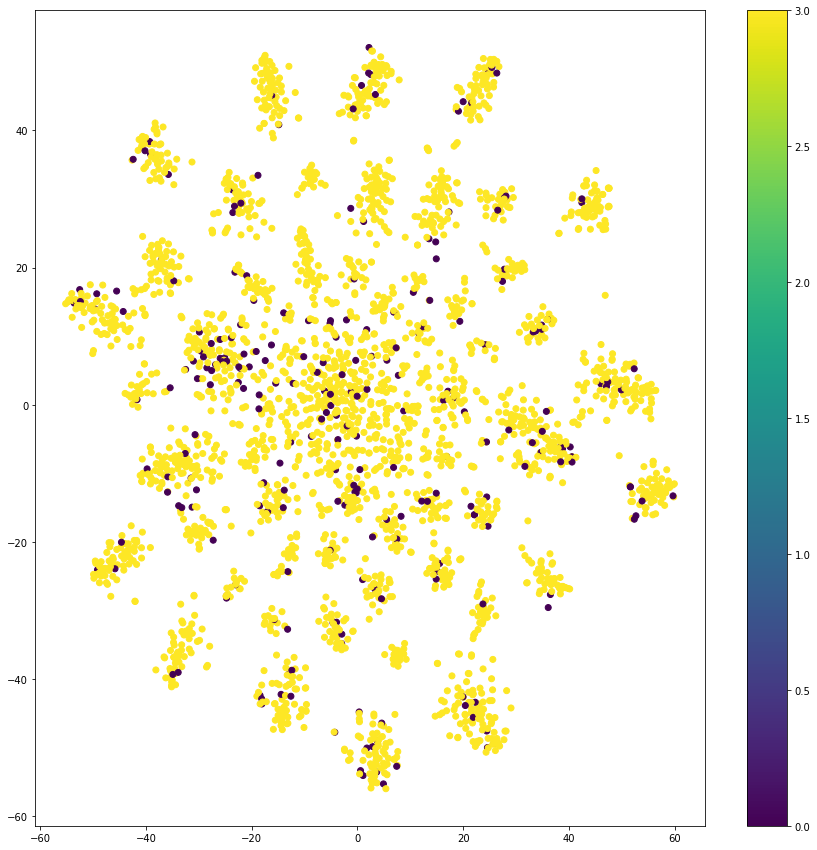

In [62]:
# plot the result according the topics
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_mnf, 0)[:, 3] ## Change the topic number here
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

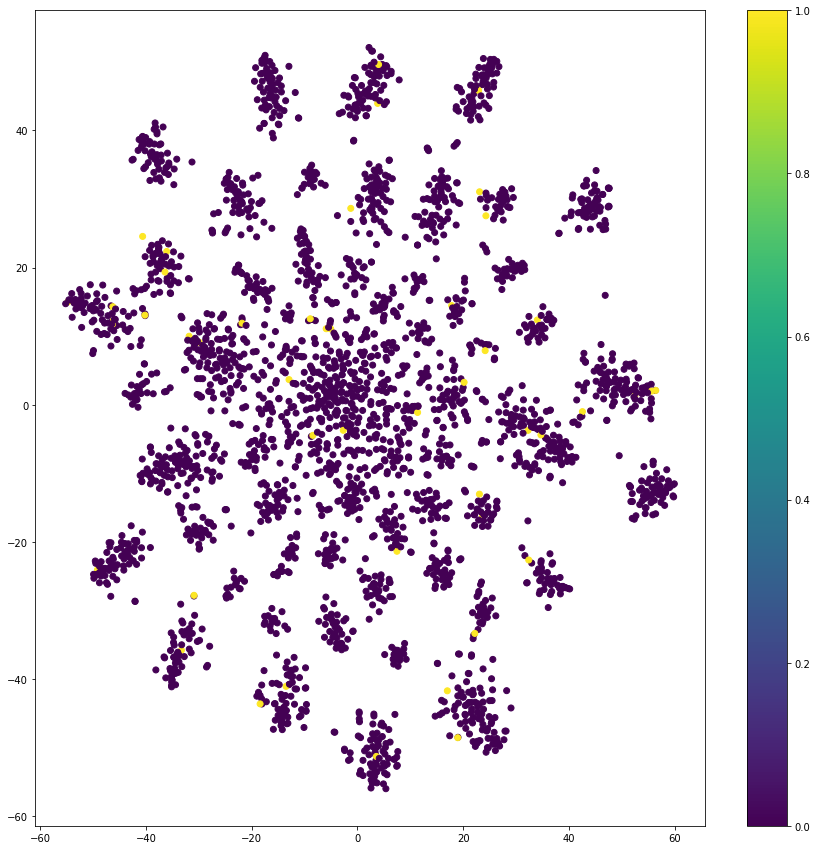

In [63]:
# plot the result according the labels
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = y_test[:, 21]  ## Change the tag position here
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

In [32]:
predict = mlb.inverse_transform(customNMF.predict(X_test))
truetag = mlb.inverse_transform(y_test)
wordtag = customNMF.predict_word(X_test)

for prediction, tags, post, keywords, title in zip(predict, truetag, list(X_test['TText']), wordtag, list(X_test['TTitle'])):
    print(title)
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('KEYW --> {}'.format(keywords))
    print('--------------------------------------------')

php custom parser non-format text
tri creat project help student studi various area idea piec raw text contain quiz question answer want pars question header answer option insert databas howev text proper format due larg amount question answer around ~20k per total afford time manual insert format text raw text look like tri creat php function pars text proper howev get get past random line break space etc tri obtain code far produc see current output doe match far tri obtain thank advanc

TRUE --> ('arrays', 'parsing', 'php', 'regex')
PRED --> ('ajax', 'javascript', 'php', 'text', 'wordpress')
KEYW --> ['text' 'box' 'header' 'long' 'enter' 'php' 'ajax' 'wordpress' 'javascript'
 'index' 'like' 'would' 'look' 'way' 'someth']
--------------------------------------------
send multipl http request time php
tri get page meta tag descript given url url array loop send curl get request get page meta take lot time process ani way process url simultaneuosli time mean send request url time recei

TRUE --> ('rust',)
PRED --> ('string', 'time')
KEYW --> ['time' 'first' 'second' 'one' 'everi' 'like' 'would' 'look' 'way' 'someth'
 'string' 'convert' 'charact' 'format' 'extract']
--------------------------------------------
upload simpl file server almost complet
'm tri upload file input console.log show file object correct server 'm get html jqueri server-sid

TRUE --> ('html', 'java', 'jquery', 'spring')
PRED --> ('csv', 'file', 'laravel', 'pdf', 'server', 'sql')
KEYW --> ['upload' 'progress' 'laravel' 'storag' 'photo' 'server' 'client' 'sql'
 'side' 'certif' 'file' 'csv' 'read' 'path' 'pdf']
--------------------------------------------
extern javascript/html work veri basic basic/beginn
html file script googl chrome say localexcept referenceerror onclick1 defin htmlinputelement.onclick .js html file save desktop folder

TRUE --> ('html', 'javascript')
PRED --> ('html', 'javascript', 'post')
KEYW --> ['html' 'javascript' 'index' 'display' 'templat' 'folder' 'copi' 'locat'
 'deploy

window command promt full eror give php artisan command anyon ani suggest

TRUE --> ('laravel',)
PRED --> ('ajax', 'javascript', 'linux', 'php', 'wordpress')
KEYW --> ['window' 'applic' 'system' 'machin' 'linux' 'php' 'ajax' 'wordpress'
 'javascript' 'index' 'method' 'call' 'pass' 'refer' 'thread']
--------------------------------------------
turn round corner epplus excelchart
went properti tri follow

TRUE --> ('c#', 'wpf')
PRED --> ('checkbox', 'excel', 'plot', 'vba')
KEYW --> ['set' 'properti' 'checkbox' 'check' 'true' 'excel' 'cell' 'sheet' 'vba'
 'workbook' 'chart' 'bar' 'show' 'plot' 'axi']
--------------------------------------------
regex singl char prefix number
littl bit struggl obtain regex case valid case f33434343 invalid case abc23232 c2242422342 mean onli f prefix otherwis onli number tri f 0-9 help pleas suggest idea solut thank advanc

TRUE --> ('java', 'regex')
PRED --> ('audio', 'random', 'video')
KEYW --> ['number' 'phone' 'index' 'want' 'random' 'video' 'play' 're

find div beautifulsoup
want extract block text within div tag seen sever post discuss various div attribut tag want attribut 's div excerpt html dozen div tag abov onli one div howev ani find method `` div '' return much tri follow string tag search pickup everi tag contain div isol parent div search within still return much ani idea div seem common tag/str isol

TRUE --> ('beautifulsoup', 'html', 'python-3.x')
PRED --> ('filter', 'search', 'xml')
KEYW --> ['tag' 'xml' 'insid' 'attribut' 'follow' 'div' 'parent' 'width' 'height'
 'insid' 'search' 'filter' 'box' 'index' 'match']
--------------------------------------------
webpack webpack-dev-serv hot reload doe work
know ask mani time ca n't seem find right combin tweak get work everyth build everyth run webpack build output even show hot replac enabl chang compon rebuild success noth chang reload page webpack.config.j index.j tri drop index.html file ./assets/dist folder set contentbas folder run reload still doe n't work chang

TRUE -

 'laravel' 'chart' 'bar' 'show' 'plot' 'axi']
--------------------------------------------
access content directori pass url paramet pass browser
first chromecast reason want current limit solut chrome browser 'd like packag directori imag launcher batch file cmd sh html file html file complet self contain import bat file would contain someth like current use manual select file append pictur select directori master slide list follow via timer object display slide read far kudo plus auxiliari code german desir solut work show slideshow base user input object desir packag thing user doubl click bat file browser proceed show slide show question take directori pass get graphic file directori use alreadi work code spent last six hour research question much stackoverflow appear current imposs quest thank tom

TRUE --> ('javascript',)
PRED --> ('csv', 'file', 'html', 'javascript', 'pdf')
KEYW --> ['file' 'csv' 'read' 'path' 'pdf' 'like' 'would' 'look' 'way' 'someth'
 'html' 'javascript' 'inde

PRED --> ('fetch', 'random')
KEYW --> ['number' 'phone' 'index' 'want' 'random' 'event' 'trigger' 'calendar'
 'fire' 'click' 'data' 'fetch' 'fram' 'frame' 'use']
--------------------------------------------
simul mous click inpout32
master send key press ca n't figur send mous click write out32 function order send left mous click

TRUE --> ('c', 'c++')
PRED --> ('email', 'laravel')
KEYW --> ['messag' 'email' 'send' 'mail' 'laravel' 'key' 'primari' 'foreign' 'press'
 'constraint' 'event' 'trigger' 'calendar' 'fire' 'click']
--------------------------------------------
show static content websit onli authent user use asp.net ii 7.0
tri show static content websit like pdf file imag onli authent user use asp.net form authent author rule put root config file follow configur folder pdf file imag config file follow configur work login websit see file get redirect login page issu see file even log websit still redirect like log tri see file pleas help wrong

TRUE --> ('asp.net', 'vb.net')
PRED


TRUE --> ('bash', 'linux')
PRED --> ('csv', 'file', 'pdf')
KEYW --> ['folder' 'copi' 'locat' 'deploy' 'subfold' 'creat' 'new' 'dynam' 'instanc'
 'add' 'file' 'csv' 'read' 'path' 'pdf']
--------------------------------------------
resttempl certif issu
pass certif resttempl request header get forbidden error display certif inform end befor make call web servic use code pass certif request header

TRUE --> ('https', 'spring-boot', 'ssl')
PRED --> ('http', 'post')
KEYW --> ['request' 'post' 'header' 'send' 'http' 'notif' 'push' 'activ'
 'background' 'devic' 'error' 'follow' 'tri' 'occur' 'got']
--------------------------------------------
foreach paramet refer danger
knew danger pass item refer foreach particular one must reus variabl pass refer becaus affect array like exampl array string `` modifi '' bite content array get modifi insid function should_not_modifi even though n't pass array valu array string `` modifi '' 'm tempt go whole codebas insert unset item foreach array item sinc

class friend function function defin insid namesapc differ header file access privat member
simplifi version much larger program work howev issu present seem find solut anywher class name user contain one privat data member string hold user 's usernam one constructor accept string argument friend function display object 's usernam data member defin friend function insid namespac differ header file howev access privat data memeb object figur whi

TRUE --> ('c++', 'visual-studio', 'xcode')
PRED --> ('class', 'fetch', 'object')
KEYW --> ['class' 'constructor' 'custom' 'main' 'inherit' 'object' 'properti'
 'serial' 'access' 'game' 'data' 'fetch' 'fram' 'frame' 'use']
--------------------------------------------
pyqt groupbox align
got real problem make align header qgroupbox chang width border initi someth like first filter chang stylesheet groupbox header filter `` goe '' like second one ani way set center align bold frame groupbox

TRUE --> ('pyqt5', 'python')
PRED --> ('checkbox', 'filt

--------------------------------------------
tensorflow 's quantize_graph.pi break model
run fine output graph much smaller size origin graph 17mb 4mb seem complet break model imag give return velvet realli low confid score ~0.01 'm use python 3.4.2 tensorflow 1.3.0 caus

TRUE --> ('python', 'python-3.x', 'tensorflow')
PRED --> ('django', 'python', 'tensorflow')
KEYW --> ['model' 'train' 'viewmodel' 'tensorflow' 'layer' 'django' 'pi' 'templat'
 'admin' 'urls' 'python' 'use' 'modul' 'dictionari' 'execut']
--------------------------------------------
menuicon defin react app load scss file
app use import statement load scss file build fine load browser error new error append empti string src sidebar.j

TRUE --> ('reactjs',)
PRED --> ()
KEYW --> ['react' 'nativ' 'navig' 'nat' 'state' 'load' 'jqueri' 'chrome' 'content'
 'photo' 'error' 'follow' 'tri' 'occur' 'got']
--------------------------------------------
polygon flicker call setpoint googl map
android app use googl map sdk 11.6.2 'm d

PRED --> ()
KEYW --> ['like' 'would' 'look' 'way' 'someth' 'output' 'print' 'log' 'differ' 'whi'
 'work' 'doe' 'fine' 'tri' 'seem']
--------------------------------------------
angular googl map integr issu
tri integr googl map angular project lat-lng inform get inject ifram url 's display map show ani error consol well templat sourc angular code

TRUE --> ('angular', 'google-maps', 'javascript', 'typescript')
PRED --> ('angular', 'redirect', 'url')
KEYW --> ['googl' 'map' 'sheet' 'cloud' 'find' 'angular' 'servic' 'js' 'angularj'
 'applic' 'url' 'redirect' 'com' 'www' 'rewrit']
--------------------------------------------
get valu max_old_space_s code
understand possibl set maximum memori usag limit applic like possibl get valu max_old_space_s code

TRUE --> ('memory', 'node.js')
PRED --> ('checkbox',)
KEYW --> ['valu' 'attribut' 'count' 'want' 'null' 'like' 'would' 'look' 'way'
 'someth' 'set' 'properti' 'checkbox' 'check' 'true']
--------------------------------------------
convert m

TRUE --> ('html', 'javascript', 'jquery')
PRED --> ('button', 'html', 'javascript')
KEYW --> ['button' 'click' 'press' 'radio' 'submit' 'html' 'javascript' 'index'
 'display' 'templat' 'like' 'would' 'look' 'way' 'someth']
--------------------------------------------
date tolocaledatestr chrome vs electron
consid javascript applic run list item item field creat date basic display date local format consid applic run machin get two differ date time format format output

TRUE --> ('date', 'electron', 'google-chrome', 'javascript')
PRED --> ('date', 'time')
KEYW --> ['item' 'menu' 'add' 'recyclerview' 'ad' 'date' 'day' 'format' 'start'
 'rang' 'time' 'first' 'second' 'one' 'everi']
--------------------------------------------
python oper short circuit
detail explan whi take longer oper like loop also way tell oper `` stop loop '' onc valu found alreadi default behavior 'm see lastly- anoth operator/funct skip doe 'm talk regard `` short-circuit ''

TRUE --> ('python',)
PRED --> ('python',)

head tell 's much fun sensit analysi data python excel 's whi initi import lot data excel follow code work fine would like input improv see code read certain column excel sheet column start end place onli differ last eight line column nr small chang array name let 's say want one hundr time could someth simpler n't copy-past slight modifi two line edit end key use var h

TRUE --> ('arrays', 'excel', 'numpy', 'python')
PRED --> ('excel', 'python', 'vba')
KEYW --> ['excel' 'cell' 'sheet' 'vba' 'workbook' 'python' 'use' 'modul'
 'dictionari' 'execut' 'column' 'datafram' 'panda' 'two' 'contain']
--------------------------------------------
display data databas tab panel view
want make edit form use tab panel im confus display data databas tab panel becaus tab panel call id dont know place control method display data must call function control display data form tab panel view control function

TRUE --> ('css', 'database')
PRED --> ('ajax',)
KEYW --> ['tab' 'open' 'close' 'modal' 'fragment' 

--------------------------------------------
save multi dimension array realm use swift
first time post question forgiv someth wrong would realli appreci somebodi could explain way save multi dimension array realm use swift look lot forum unfortun 'm stump tri solv week array call sequenc made int array var sequenc need save realm also need abl add remov array within array call method somebodi solut 'd extrem grateful thank

TRUE --> ('realm', 'swift')
PRED --> ('post', 'random')
KEYW --> ['save' 'post' 'db' 'comment' 'datafram' 'array' 'convert' 'sum' 'numpi'
 'random' 'like' 'would' 'look' 'way' 'someth']
--------------------------------------------
subtract multipl tabl sql
im tri achiev full list partno 's part tabl minus partno ordereditem tabl beleiv would need left outter join like still bit stuck one right track

TRUE --> ('mysql', 'sql')
PRED --> ('join', 'list', 'mysql', 'sql')
KEYW --> ['like' 'would' 'look' 'way' 'someth' 'tabl' 'sql' 'join' 'insert' 'mysql'
 'list' 'drop' 

KEYW --> ['number' 'phone' 'index' 'want' 'random' 'html' 'javascript' 'index'
 'display' 'templat' 'upload' 'progress' 'laravel' 'storag' 'photo']
--------------------------------------------
sql get date one digit day month
need date follow format 1.1.2018 lead need check date format doe n't exist way way would build store proc function convert date varchar delet need better solut alreadi get result without build store proc function ani help great appreci

TRUE --> ('date', 'sql')
PRED --> ('date',)
KEYW --> ['date' 'day' 'format' 'start' 'rang' 'delet' 'oper' 'remov' 'space'
 'record' 'like' 'would' 'look' 'way' 'someth']
--------------------------------------------
2d array rotat
2d array would like flip clockwis homework assign follow output code tri flip array creat new temporari one want second array first column understand wrong code follow final result temp array correct purpos project code part want nest loop `` flip '' array without move valu

TRUE --> ('arrays', 'java')
PRE

TRUE --> ('c#', 'unity3d')
PRED --> ('post',)
KEYW --> ['load' 'jqueri' 'chrome' 'content' 'photo' 'like' 'would' 'look' 'way'
 'someth' 'save' 'post' 'db' 'comment' 'datafram']
--------------------------------------------
qt qmodelindex :sibl return parent qmodelindex
qabstractitemmodel grmodel call result grsrcprtidx == grsrcidx1 grsrcprtidx contain data expect grsrcprtidx grsrcidx2 contain expect data sibl expect grsrcidx1 == grsrcidx2 seem sibl function provid defaut implement someth similar might caus sibil function doe deliv sibl qmodelindex miss implement function qabstractitemmodel qt version use qt 5.10.0 mingw

TRUE --> ('c++', 'model-view-controller', 'qt')
PRED --> ('function',)
KEYW --> ['result' 'give' 'differ' 'calcul' 'one' 'return' 'null' 'statement' 'true'
 'log' 'function' 'call' 'pass' 'argument' 'use']
--------------------------------------------
android build crash sign build
'm android app build perfect fine debugg app soon set debugg fals start crash gradl conso

success implement webhook php applic unsur verifi sm-signatur header webhook callback sent post request includ follow request header use verifi request come surveymonkey addit python savvi 'm also veri familiar php 's hash digest cryptograph function interpret php and/or explain verif would perform php edit appreci effort point right direct tri code along code sever answer none produc result need furthermor 'm ask specif context surveymonkey document php implement surveymonkey 's v3 webhook verif find duplic question specif perform verif far tri variat raw unpars post messag bodi api_sig sm-signatur header valu api_key key pass sm-apikey header api_client_id client id actual ident sm-apikey none produc valu match sm-signatur output time length sm-signatur suspect anoth encod requir befor and/or hmac digest 'm knowledg enough know would edit thank general kandalaft 's sampl code abl find solut n't grasp data pass key suggest help combin inform come across research issu allow success per

getaddrinfo eai_again registry.npmjs.org:80
hi guy 'm tri publish angular librari npm login get -version node 8.9.3 -version npm 5.5.1 behind authent proxi alreadi configur proxi https-proxi npm config set proxi http // usernam pa55w0rd proxyhostnam port npm config set https-proxi http // usernam pa55w0rd proxyhostnam port thank attent

TRUE --> ('angular', 'node.js', 'npm', 'proxy')
PRED --> ('checkbox', 'npm')
KEYW --> ['set' 'properti' 'checkbox' 'check' 'true' 'instal' 'npm' 'packag'
 'version' 'pip' 'login' 'password' 'access' 'log' 'authent']
--------------------------------------------
kotlin vertx mongo manag async crud function
friend green hand vertx mongo face difficult problem code piec follow mongo client 's wrapper class verticl code see guy copi code tri get result question ps || mean togeth

TRUE --> ('kotlin', 'mongodb')
PRED --> ()
KEYW --> ['code' 'use' 'help' 'follow' 'make' 'result' 'give' 'differ' 'calcul'
 'one' 'folder' 'copi' 'locat' 'deploy' 'subfold']
-------

 'null' 'chart' 'bar' 'show' 'plot' 'axi']
--------------------------------------------
proper combin numer featur text bag word spark
use spark 2.2 linearsvc model tweet data input tweet 's text pre-process hash-tfidf also month follow 30,000 word featur wo n't swamp month vectorassembl smart enough handl possibl get best featur model

TRUE --> ('apache-spark', 'machine-learning', 'scala')
PRED --> ('javascript', 'tensorflow', 'text')
KEYW --> ['text' 'box' 'header' 'long' 'enter' 'model' 'train' 'viewmodel'
 'tensorflow' 'layer' 'input' 'focus' 'enter' 'javascript' 'multipl']
--------------------------------------------
scope variabl c use pointer function
valu p 2nd printf statement execut return n whi

TRUE --> ('c', 'function', 'pointers')
PRED --> ()
KEYW --> ['return' 'null' 'statement' 'true' 'log' 'variabl' 'environ' 'declar'
 'env' 'pass' 'valu' 'attribut' 'count' 'want' 'null']
--------------------------------------------
convert back forth textsiz fontsiz xamarin.android
'm

PRED --> ('fetch', 'jar', 'spring', 'tensorflow')
KEYW --> ['spring' 'boot' 'jar' 'applic' 'depend' 'model' 'train' 'viewmodel'
 'tensorflow' 'layer' 'data' 'fetch' 'fram' 'frame' 'use']
--------------------------------------------
variabl angular modal ui watch
javascript html

TRUE --> ('angularjs',)
PRED --> ('angular', 'html', 'javascript')
KEYW --> ['html' 'javascript' 'index' 'display' 'templat' 'variabl' 'environ'
 'declar' 'env' 'pass' 'angular' 'servic' 'js' 'angularj' 'applic']
--------------------------------------------
stop ffmpeg process finish process c
tri stop ffmpeg process onc finish want abl find way done problem ffmpeg doe tell process stop finish execut cant use waitforexit call tri forc ffmpeg close finish execut work tri cmd thing c ffmpeg close soon command execut ani way forc ffmpeg process close process done

TRUE --> ('c#', 'timer')
PRED --> ('audio', 'time', 'video')
KEYW --> ['video' 'play' 'record' 'could' 'audio' 'tab' 'open' 'close' 'modal'
 'fragment' 


TRUE --> ('batch-file',)
PRED --> ('string',)
KEYW --> ['string' 'convert' 'charact' 'format' 'extract' 'result' 'give' 'differ'
 'calcul' 'one' 'work' 'doe' 'fine' 'tri' 'seem']
--------------------------------------------
docker compos use exist imag instal addit modul
use pretti easi docker setup includ docker-compos docker-sync follow file docker-compose-dev.yml docker-compose.yml docker-sync.yml imag use bylexus/apache-php7 support curl tool like vim instal contain question instal curl vim keep use imag apach need chang file abov thank

TRUE --> ('docker', 'docker-compose')
PRED --> ('docker', 'npm')
KEYW --> ['imag' 'display' 'background' 'docker' 'img' 'instal' 'npm' 'packag'
 'version' 'pip' 'run' 'command' 'docker' 'program' 'start']
--------------------------------------------
alloc tensor gpualloc buffer avail immedi
buffer avail immedi wait devic stream readi

TRUE --> ('tensorflow',)
PRED --> ('android', 'audio', 'video')
KEYW --> ['video' 'play' 'record' 'could' 'audio' 

In [18]:
params = {'clf_ntopics': 3,
 'clf_ntopwords': 10,
 'clf_merge':True,
 'clf_serie':['TText', 'TTitle'],
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'nmf_alpha':0,
 'nmf_l1_ratio':0,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'clf_ntopwords': [5],
              'clf_merge': [True, False],
              'clf_serie':[['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']],
              'nmf_alpha':np.arange(0,.251,.25/4),
              'nmf_l1_ratio':np.arange(0,.1251,.125/3),
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=48.08333333333333, total= 1.3min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=42.83333333333333, total= 1.4min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_rati

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  8.9min


[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=44.16666666666667, total=  32.7s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=44.58333333333333, total=  53.3s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333, score=46.666666666666664, total=  33.3s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=

[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0, score=53.833333333333336, total= 1.4min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=52.33333333333333, total=  40.8s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=50.16666666666667, total= 1.2min
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.125, score=30.083333333333336, total= 2.0min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.125, score=33.949999999999996, total= 2.1min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667, score=30.25, total= 1.2min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0, score=30.916666666666657, total= 1.8min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'T

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.25, nmf_l1_ratio=0.125, score=31.116666666666664, total=  47.4s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=33.86666666666667, total= 2.5min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=27.11666666666666, total= 2.2min


[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 50.6min


[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=33.86666666666667, total= 2.5min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=27.11666666666666, total= 2.3min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333, score=33.86666666666667, total= 2.4min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopw

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.1875, nmf_l1_ratio=0.125, score=30.083333333333336, total= 1.8min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=34.86666666666666, total= 1.8min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=27.500000000000004, total= 2.4min
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667, score=27.366666666666667, total=  

[Parallel(n_jobs=3)]: Done 160 out of 160 | elapsed: 71.2min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=10, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0, nmf_init='nndsvd',
     nmf_l1_ratio=0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngr...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'clf_ntopwords': [5], 'clf_merge': [True, False], 'clf_serie': [['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']], 'nmf_alpha': array([ 0.    ,  0.0625,  0.125 ,  0.1875,  0.25  ]), 'nmf_l1_ratio': array([ 0.     ,  0.04167,  0.08333,  0.125  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [19]:
clf.best_score_

51.958333333333336

In [20]:
clf.best_params_

{'clf_merge': True,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle', 'TCode'],
 'nmf_alpha': 0.1875,
 'nmf_l1_ratio': 0.0}

In [21]:
{**params, **clf.best_params_}

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle', 'TCode'],
 'nmf_alpha': 0.1875,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

## Gridsearch to optimize tags research

In [22]:
#Metrics creation

scorer = make_scorer(f1_score, average='micro')
#scorer = make_scorer(label_ranking_average_precision_score, needs_proba=False)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}


In [23]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 100,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'vect_1_max_df': [1., .95, .9],
              'vect_1_min_df': [1, 10, 20],
              'vect_1_max_features':[15000, 12000, 17000],
              'vect_1_ngram_range':[(1,1)],
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.09367805914644944, total=  16.4s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.12836374884008658, total=  22.6s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.09318053729100133, total=  13.2s
[CV] vect_1_max_df=1.0, vect_1_max_features=150

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  9.0min


[CV] vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.09435916752989923, total= 1.6min
[CV] vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.09318053729100133, total=  13.2s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.12564122800094701, total=  15.4s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.11726743270895638, total= 2.0min
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_m

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed: 16.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=100, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.95, 0.9], 'vect_1_min_df': [1, 10, 20], 'vect_1_max_features': [15000, 12000, 17000], 'vect_1_ngram_range': [(1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [24]:
clf.best_score_

0.11102090399326803

In [25]:
clf.best_params_

{'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 10,
 'vect_1_ngram_range': (1, 1)}

In [26]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.10479929492829099

In [27]:
predict = mlb.inverse_transform(clf.predict(X_test))
truetag = mlb.inverse_transform(y_test)

for prediction, tags, post in zip(predict, truetag, list(X_test['TText'])):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('--------------------------------------------')

piec code work fine ie11 soon use `` emul '' select ie10 get follow error messag investig line get code give troubl puzzl fact code work fine yesterday even ie start give problem someth 'm miss

TRUE --> ('javascript',)
PRED --> ('web',)
--------------------------------------------
'm tri `` translat '' word fiction languag purpos written php-script translat word follow unfortun alway get `` c '' result anybodi idea done wrong thank answer advanc filip zocktan

TRUE --> ('php',)
PRED --> ('express', 'laravel', 'php', 'regex', 'session')
--------------------------------------------
creat dynam dropdown list use product make model creat dropdown list select differenti select valu name current script return valu although differ product select also center select id valu dropdown list valu ani help provid appreci

TRUE --> ('html', 'javascript', 'jquery')
PRED --> ('list',)
--------------------------------------------
alway wonder git fetch determin object need transfer client decid sinc do

function return jsx need html output fill data-tooltip attribut need jqueryui render tooltip react render object object rather html insid data-tooltip attribut exampl second this.hello work html return prove hello function proper use jsx first this.hello call result data-tooltip= '' object object '' insert html insid tag attribut

TRUE --> ('reactjs',)
PRED --> ('fetch', 'object', 'plot')
--------------------------------------------
sure possibl jqueri shall use php pass valu queri string click next button tri chang valu personnelid increment everi click click previous button tri chang valu personnelid decreas everi subsequ click summari link menu_link=sum.php personnelid=10 frm=test

TRUE --> ('jquery', 'php')
PRED --> ('button', 'laravel', 'php', 'session')
--------------------------------------------
tri generat svg allow user websit download svgs pngs read get extern imag includ download png tri get font png correct seem answer ad .. base64 encod woff2 font use text like font get d

main.storyboard button need chang imag base wether app connect home wifi network cloud certain devic gave button tag number viewdidload check connect chang imag need vieddidload look like function veri well today ad new function call viewdidload function app crash direct startup tell line ‘ let mybutton ’ unexpect found nill function call viewdidload would mean humbl opinion storyboard load befor viewdidload method start becaus storyboard load unwrap would yield ‘ nill ’ anybodi clue solv

TRUE --> ('ios', 'swift')
PRED --> ('ajax', 'docker', 'mongodb', 'mysql')
--------------------------------------------
seri imag want mouseov replac could implement style someth like implement would requir whole style block everi imag 'd rather want one unifi style specifi ismouseov properti tag actual control like thought someth templat abl put piec togeth make work

TRUE --> ('c#', 'wpf', 'xaml')
PRED --> ('docker',)
--------------------------------------------
function get object list entri list o

sharepoint site need read column rich textbox anoth applic although data read site shown applic data come html tag convert rich text plain text without referenc rtf file

TRUE --> ('c#',)
PRED --> ('fetch', 'input', 'plot', 'web')
--------------------------------------------
good morn regard process upload video file bucket want suggest notifi pub/sub subscrib file upload notif bucket link topic success upload bucket publish method use callback promis return upload method publish messag topic

TRUE --> ('node.js',)
PRED --> ('csv', 'file')
--------------------------------------------
follow html want get far got follow code produc howev first item sup class well n't want could provid clue n't want refer 2nd 3rd posit list sinc n't htmls would 1st posit

TRUE --> ('html', 'python', 'web-scraping')
PRED --> ('angular', 'django', 'html', 'javascript', 'list', 'pip', 'python')
--------------------------------------------
see 1000s crash report relat notif viabl way debug check app code not

scroll content laravel-bas web app arrow anchor tag left right side screen code question would like click anchor press left right arrow key keyboard keycod internet search result found piec code text box button combin may close solut howev doe work textbox onli anchor tag mani thank advanc ani help

TRUE --> ('html', 'javascript', 'jquery')
PRED --> ('css',)
--------------------------------------------
imageview call `` cardimgview '' want load two imag scroll horizont tri follow way case abl scroll onli imag also chang anyon idea correct thank advanc

TRUE --> ('image', 'ios', 'swift')
PRED --> ('ajax', 'css', 'docker')
--------------------------------------------
new azur work aw lambda quit time want make lambda function written py 2.7 work azur function creat new function python option thus creat javascipt creat new file delet js file tri run python file alway show error

TRUE --> ('python-2.7',)
PRED --> ('csv', 'django', 'file', 'pip', 'python')
----------------------------------

standard way implement input devic android game consol button standard `` keypress '' event emit could n't find ani resourc type subject anyon could point right direct would appreci

TRUE --> ('android',)
PRED --> ()
--------------------------------------------
tri keep back button bottom page nest scroll view fill space stat relat layout back button bottom page current fit stat top push back button bottom page sinc 's fit page want look like

TRUE --> ('android', 'android-layout')
PRED --> ('css', 'swift')
--------------------------------------------
two panda datafram want creat new actor-movi datafram artist 's name first column subsequ column movi actor appear want use `` nconst '' tabl search `` principalcast '' column everi movi tabl actor appear one `` principalcast '' posit 1-7 add movi titl actor appear new actor-movi datafram column ultim want tabl lot column movi artist part tri merg pivot datafram success also tri use itertupl two loop itertupl take hour yield result entir 

exampl column email address want remov everyth befor sign everyth attain compani name want creat new column look like function use attain new column

TRUE --> ('excel', 'function')
PRED --> ('input',)
--------------------------------------------
'm face veri weird problem regard dynam set input valu jqueri initi state target input follow note input field generat joomla framework may matter n't know set valu regular way get result valu attribut set tri way give expect result whatev reason valu empti form submit even stranger give focus birthdat field click submit form valu pass correct would point problem occur onli input field deal date datetim valu someon help

TRUE --> ('forms', 'jquery')
PRED --> ('input',)
--------------------------------------------
want list googl drive folder file nest json tree use python class want data point structur object want wrap whole script class tree like thank

TRUE --> ('class', 'python')
PRED --> ('csv', 'file')
-------------------------------------

want lint file current recurs directori print onli file error assign variabl use lint finish exampl fail ./app/model/example.php abov code doe n't find ani error run php -l ./app/model/example.php error return

TRUE --> ('bash', 'php')
PRED --> ('csv', 'django', 'file', 'laravel', 'model', 'php', 'session')
--------------------------------------------
want creat map store rout one point anoth distanc use valu map distanc b equal distanc b get w without push w map becaus v w rout p.s word possibl overrid rule one rout equal anoth rout use rout key map

TRUE --> ('dictionary', 'go')
PRED --> ()
--------------------------------------------
'm make hospit websit project tri get patient pick date order get appoint doctor 'm tri make datetimepick work onli empti textbox show master page get appoint page

TRUE --> ('asp.net', 'c#', 'twitter-bootstrap')
PRED --> ()
--------------------------------------------
built neural network recogn handwritten digit java train network use mnist dataset ha

develop function statement insid function work fine get insid get error error code illeg mix collat utf8_bin implicit latin1_swedish_ci numer oper suppress everyth work fine check collat tabl databas utf8_bin mani advic alreadi read work ani idea

TRUE --> ('mysql',)
PRED --> ()
--------------------------------------------
ani reason whi would print desir console.log statement consol allow illeg charact i.e. ani charact number 0-9 log consol right 'm get everi button press log consol even one n't want console.log statement want behaviour code inconsist question whether someth wrong ide chrome note also use keyup problem

TRUE --> ('javascript', 'jquery')
PRED --> ('random',)
--------------------------------------------
experi chrome js consol found someth bit puzzl run follow consol consol print undefin howev run print screenshot result consol could anyon explain whi differ behavior

TRUE --> ('javascript',)
PRED --> ('docker',)
--------------------------------------------
code work de

want see could help littl problem python script respons analyz text file need get python analyz last text file creat directori ani way make script run chang valu variabl name last creat file attach script make easier understand thank chang name text file line

TRUE --> ('email', 'python')
PRED --> ('csv', 'file', 'input')
--------------------------------------------
would like ask ok save author token file specif folder faster everi request connect databas compar token save tabl thank answer

TRUE --> ('php', 'security')
PRED --> ('csv', 'file')
--------------------------------------------
'm get api extern sourc document given hit endpoint address data 'm look appear json format question use web api mvc applic get json display

TRUE --> ('asp.net-web-api', 'json', 'model-view-controller')
PRED --> ('api', 'rest', 'video', 'web')
--------------------------------------------
get acc sampl signal process speechrecognitionengin c basic program recogn speech well get access particular samp

use peewe project tabl file name id 's auto increment primari key need get id valu api insert function call model insert function create_us return valu could get id valu seem could id use sqlalchemi know openstack use sqlalchemi result could get auto_incr id creat function

TRUE --> ('python',)
PRED --> ()
--------------------------------------------
refer data hive tabl need access refer data main hive queri howev possibl join refer tabl main hive queri possibl extract data refer tabl put map access hive queri

TRUE --> ('hadoop', 'hive')
PRED --> ('fetch', 'mongodb', 'mysql', 'plot')
--------------------------------------------
html want check articl tag avail use webdriv java html code first need check articl tag avail avail move insid div tag skip pleas guid

TRUE --> ('html', 'java', 'selenium-webdriver', 'xpath')
PRED --> ('css', 'java', 'xml')
--------------------------------------------
basic want send imag load phaser websocket socket.io howev seem imag kind recursive/circular

current array structur everi time run array_column max_weight get empti array result 'm suppos use return array max workaround

TRUE --> ('arrays', 'php')
PRED --> ('object',)
--------------------------------------------
client use code upload file json flask server server flask server side could save metadata file server would like save complet `` post '' raw binari file mention thread tri use get empti file whatev method use right `` foo '' get_data stream.read use onli `` file '' got error messag flask server

TRUE --> ('file', 'flask', 'post', 'python')
PRED --> ('csv', 'file', 'post', 'wordpress')
--------------------------------------------
tri build dataset onlin questionnair questionnair particip ask name item item repres number order mention doe matter afterward particip ask rank item import least import order matter right three column `` name item '' `` item rank '' `` rank '' last column repres posit case rank thus idea would look number first column `` name item '' search p

therefor code actual execut android devic function ident might veri differ origin .class file structur way get content .oat file and/or jit cach devic n't mind root

TRUE --> ('android',)
PRED --> ('csv', 'file')
--------------------------------------------
multithread applic link list lot place code travers link list one place node remov place link list travers need protect ie happen parallelli place remov happen need happen none travers place action mutex lock place travers place delet place work would slow applic whole plan variabl semaphor would increment befor travers start decrement travers end increment decrement protect mutex variabl delet place would work hold mutex variabl count semaphor indic nobodi travers link list would work right way design situat better way ani help appreci tia

TRUE --> ('algorithm', 'c++', 'multithreading')
PRED --> ('graph', 'list', 'npm')
--------------------------------------------
set default custom time rang amchart candlestick chart candlestick 

draw function app photo 's work everi devic except iphon x iphon x line becom fade move upward finger movement upper 10-20 percent area view work fine follow code draw line

TRUE --> ('ios',)
PRED --> ('plot', 'swift')
--------------------------------------------
r-inla model hyperparamet to.theta from.theta function appear convert differ parameteris would conveni use convers function doe one ar1 document http //www.math.ntnu.no/inla/r-inla.org/doc/latent/ar1.pdf paramet rho repres theta_2 log rho rho hyper theta2 to.theta function x log 1+x 1-x would nice could use convert rho theta_2 let 's tri use exampl run fine use to.theta like ca n't use like anoth way specifi formula.to.theta would work

TRUE --> ('r',)
PRED --> ('pdf',)
--------------------------------------------
one page allow user fulli edit page .blade.php sinc php want prevent sql queri danger function know add event listen eloqu still use raw db queri global event listen could use block mysql queri danger function

TRUE 

case keep swaggerconfig bean like case keep swaggerconfig bean like question want onli see conditions-allergies-control item image-2 swagger ui exact write swaggerconfig bean

TRUE --> ('spring', 'spring-boot')
PRED --> ('spring',)
--------------------------------------------
mysql2 :result object available_item give someth look like well actual look like someth els hope get idea know default mysql2 result output hash figur abl refer item column refer date column i.e use tdate key get item valu creat feel like `` dirti '' code pluck method creat array array call refer array realli want hash tdate key item valu later pull one abbrevi item comma separ list item ani given date random put singl item new hash pseudocod examin hash use code tri creat hash follow get look like fed everyth one line feel tri complex also misunderstood append hash question creat hash key valu pair thing look like tdate item one new pair date thank advanc

TRUE --> ('arrays', 'ruby')
PRED --> ()
-----------------

way add checkbox addit text column header wpf datagrid without use datagridcheckboxcolumn would add checkbox grid cell particular column thank

TRUE --> ('wpf', 'xaml')
PRED --> ('excel', 'input', 'vba')
--------------------------------------------
tri updat databas column field raw sql laravel 's import mention updat code written mysql drive use postgr column name dayid updat code must use raw sql becaus make updat polygon type problem laravel automat transform dayid dayid get error tri set variabl order use updat queri also fail error fix

TRUE --> ('laravel', 'mysql', 'postgresql')
PRED --> ('input', 'mysql', 'sql')
--------------------------------------------
menu follow style item name subitem properti class menuitem itemssourc properti menu bound object type list menuitem problem `` icon '' part appear onli last item menu ultim want bind item icon doe n't seem work either ani idea caus misbehavior fix updat seen menuitem style icon creat onli one icon n't work becaus a. x shared=

'm write code json given key valu pair json need creat html div html js click button give messag object htmldivel consol show error 'm realli confus 's go backend expect output pleas let know go wrong fix thank

TRUE --> ('html', 'javascript')
PRED --> ('css',)
--------------------------------------------
mention error come call api behind firewal tri access api engineyard instanc engineyard instanc ip white list firewal get follow error ani idea

TRUE --> ('ruby', 'ruby-on-rails', 'soap', 'ssl')
PRED --> ('ajax', 'api', 'list', 'rest', 'web')
--------------------------------------------
assumpt right wrong alreadi instal use npm instal ejs-lint -- save-dev also plan add eslint project 'm guess work alongsid ejslint

TRUE --> ('ejs',)
PRED --> ('npm', 'pip')
--------------------------------------------
'm exercis atof provid k r book 4.2 howev compil follow code get instead tri still n't know 's wrong mayb problem type convers

TRUE --> ('c',)
PRED --> ()
------------------------------

tri get random dataset data tabl specif condit tri choos data condit a-c-f-h a-d-i-h j-h-e-c etc made far get 'c 'y data mysql 5.6 schema setup queri result expect

TRUE --> ('database', 'mysql', 'sql')
PRED --> ('fetch', 'plot')
--------------------------------------------
hey everyon read book sql inject author start throw term could n't understand help understand question queri level databas mean effect hacker

TRUE --> ('database', 'mysql', 'oracle', 'sql')
PRED --> ('mongodb', 'mysql', 'sql')
--------------------------------------------
devexpress gridcontrol bound custom class class look like exampl filter type tri creat `` gender ='male medic mednam paracetamol age '' possibl class construct shown perhap need implement interfac imagin would look someth like linq thank

TRUE --> ('vb.net',)
PRED --> ('list',)
--------------------------------------------
simpl form pre-popul data might edit befor save control debug saveproduct ani edit made made ui reflect product save tri ad inpu

next code html use select menu like select element defin views.pi list origin use j queri way see consol onli first valu length also show

TRUE --> ('django', 'html', 'jquery')
PRED --> ('list',)
--------------------------------------------
new laravel explor exist project code rout found express rout :get '/ index use somecontrol somemethod someon clarifi second argument express array index use somecontrol somemethod

TRUE --> ('laravel', 'php', 'routing')
PRED --> ()
--------------------------------------------
alreadi seen follow domain say example1.com purchas ssl certif anoth domain example2.com want add cname record example1 example2 enforc work ssl even purchas anoth certif example2 somewhat like sub.example1.com alreadi ssl sub.example2.com doe ssl yet per learnt ssl certif instal web server apach exampl dns level setup ssl subdomain

TRUE --> ('https', 'ssl')
PRED --> ('redirect',)
--------------------------------------------
tri simpl dropdown list tabl howev code n't seem wo

input form focus would like execut jqueri function

TRUE --> ('forms', 'input', 'javascript', 'jquery')
PRED --> ('input', 'selenium', 'svg')
--------------------------------------------
need help dynam load java-script librari use require.j n't know much require.j pleas help bit multipl java-script librari inter-depend use mani jqueri plugin use jquery.min someth like made require.config n't know right 'm place main.j pleas review code anoth problem face default.aspx place script includ tag like use document .readi place break point insid main.j befor reach breakpoint main.j document readi get execut give error wrong edit ok screw bit n't add requir call end main.j ad requir jquerymin jqueryui jquerymousewheel jqueryscrolltab jquerydatetimepickerfullmin jquerypageguid angularsanitizemin angularngmodul bootstraptagsinput notifit pdfutils1 viewerhelp pdfutils2 viewerlib viewerintegr annotatelib util transform textcompar

TRUE --> ('asp.net', 'html', 'javascript', 'jquery')
PRED --> ('ja

qa env prd env onli one docker registri push imag mean version 1.0.0 1.1.0 generat 1.1.0 latest use onli one registri fix imag version prod need manual updat prd compos file update.. mayb better two registry.. make qa autodeploy use latest.. pass push imag latest prd registry..

TRUE --> ('docker', 'docker-compose')
PRED --> ('build', 'docker', 'mysql')
--------------------------------------------
tri run program c use execl function current piec code run program look like info_proc info_proc.c file main contain printf program return `` execl bad address '' execut realli see error come

TRUE --> ('c',)
PRED --> ('csv', 'docker', 'file')
--------------------------------------------
'm tri send userid creat user databas want refer data insid userid databas regard issu 'm unawar l2giz7sx-e-aalsjp4g generat userid attach identifi would like data store thank

TRUE --> ('firebase', 'firebase-database', 'javascript')
PRED --> ('fetch', 'pdf', 'plot')
------------------------------------------

receiv follow runtim except crash report section firebas java.lang.securityexcept `` gps '' locat provid requir access_fine_loc permiss yet actual bug fact manifest file onli request coars locat permiss fine locat never androidmanifest.xml whi would miss permiss throw except note first time app crash sinc launch crash took place allview vivah7 api android 4.4.2 similar crash ani devic api 's yet also coars locat consid danger permiss well fine locat therefor request permiss coars locat runtim

TRUE --> ('android',)
PRED --> ('api', 'http', 'rest', 'web', 'xml')
--------------------------------------------
'm tri get bodi 's background chang onload linear gradient onload event done far also tri use keyfram chang background linear gradient chang sharpli

TRUE --> ('css', 'javascript', 'jquery')
PRED --> ('css',)
--------------------------------------------
veri simpl applic done python qt embed matplotlib plot would like includ standard toolbar zoom home etc plot posibl abov exampl code 

configur ssl cerbot nginx 'm tri forc use https plus www config site work perfect new site throw error browser mani redirect think example.com port redirect www.example.com www.example.com port redirect www.example.com agian config work anoth domain n't know whi

TRUE --> ('nginx', 'redirect', 'ssl', 'web')
PRED --> ('redirect',)
--------------------------------------------
follow tabl part sold particular job order number tri extract descript expens part put onto singl valu card tri day muck around calcul max top selectedvalu cant seem figur 'm sure someth simpl would appreci somebodi help retriev way see miss learn futur page filter drillthrough order number filter part list essenti want card show pump dth ele approach select top row part list sort descend amount lc far simpl calcul column measur order tabl string

TRUE --> ('database', 'excel-formula')
PRED --> ('list',)
--------------------------------------------
current creat android applic android studio school project concept c

tri creat direct custom field form abl creat direct abl updat scope issu face submit form get valu custom field ng-model null undefin becaus two way bind work see updat scope parent updat direct scope updat custom field updat input field use parent scope two way bind work file users.html app.j custom_field_directive.html function get custom field valu databas userscontroller.j user model get submit form demo

TRUE --> ('angularjs', 'html', 'javascript')
PRED --> ('django', 'input', 'mysql')
--------------------------------------------
'm build flow network two list contain node properti associ connect list base properti 'm moment iter list element iter element list b connect node atleast match properti mean visit node list b onc everi singl element list faster way connect two list mayb keep matrix properti work column properti connect base would use lot memori edit problem list contain node list skill say 1,2,3 need connect node list node list b use skill edit give peopl stack skill jo

'm tri implement bottom nav bar tabview fragment use preset provid android studio tabview convert fragment wire bottom nav bar show awkward behaviour swipe doe n't skip next tab see awkward behaviour provid code need basic 'm use preset extend fragment also click tab fragment wire doe n't show whi

TRUE --> ('android', 'android-fragments')
PRED --> ('css', 'xml')
--------------------------------------------
edit netbeans.conf file find netbeans_default_opt line add -j-dfile.encoding=utf-8 insid quotat mark insid line exampl netbeans_default_options= '' -j-dfile.encoding=utf-8 '' mention abov show help- about- system window version 10.0 run amd64 utf-8 en_us nb editor still type charact squar get unknown charact output consol fix

TRUE --> ('java', 'php')
PRED --> ('build', 'plot')
--------------------------------------------
want creat list messag subject bodi boolean flag need make function like user back offic present textbox subject bodi checkbox enter data click ani add button ad i

built custom on-screen keyboard key tap return string deleg method want forward text onto uitextfielddeleg method func textfield textfield uitextfield shouldchangecharactersin rang nsrang replacementstr string string bool last line n't work throw error call valu non-funct type uitextfield ani idea accomplish thank

TRUE --> ('ios', 'swift')
PRED --> ('ajax',)
--------------------------------------------
outset project store string resourc file myresources.resx done support possibl local softwar futur use follow syntax referenc string correct use follow onli recent come across second syntax 'm bit concern use would n't actual chang text runtim also okay resx file main project resid project littl seen local process seem involv generat new dll `` full build '' whole project doe somehow extract translat resx file dll

TRUE --> ('wpf', 'xaml')
PRED --> ('csv', 'file', 'pdf')
--------------------------------------------
want chang color slider cursor color line slider lie also want make back

In [90]:
#CustomNMF saving
with open('customNMF.pickle', 'wb') as f:
    pickle.dump(customNMF, f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('customNMF.pickle', 'rb') as f:
    customNMF = pickle.load(f)
customNMF

UnpicklingError: NEWOBJ class argument isn't a type object